# Project code for tools

## The project mainly covers 4 topics: 

```
1. Analyze the best squad for each formation in terms of all players, clubs, countries

2. Conduct comparisons between two players, two clubs or two countries, and visualized results

3. Figure out whether it is worthwile to buy a player or not through polyfit and regression

4. Find required ability for every position by Principal components analysis(PCA)
```

### At the beginning: Import all modules and dataset you need!

In [1]:
# !pip install prettytable
# !pip install msgpack
# !pip install wordcloud
from prettytable import PrettyTable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import scale
import wordcloud
import re
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
df = pd.read_csv('CompleteDataset_modified.csv')

### Then: Select and clean data, creating new datasets to make analysis more efficiently!

```Important Notes: 
It takes long time to run the following cleaning codes! 
So you don't have to run it. We have finished it and save two datasets in github!
```

#### The steps of cleaning are as following:

<li>Find the columns we need to use. </li>
<li>Drop the line for which has NaN </li>
<li>Use re to fix the problem that has '+','-' in the value and calculate it into int.
          Example: '10+9' --> 19; '20-9' --> 11  </li>
<li>Save the new data to 'CompleteDataset_modify.csv'</li>
<li>Remove '€' in some value, uniform the currency unit and transform value into float type.
        Example: '€ 10K' --> 10000.00; '€ 1M' --> 1000000.00   </li>
<li>Save the new data to 'CompleteDataset_modified.csv'</li>

In [2]:
df = pd.read_csv('CompleteDataset.csv')
df.dropna(inplace = True) 
import re
name = ['special','Finishing','Attack_suport','SupplemetalDefence']
l = ['RB','LM','RM','CF','CDM','ST','LW','CM','RWB','CB','LWB','RW','CAM','LB']
variables =  ['Age',
 'Special',
 'Acceleration',
 'Aggression',
 'Agility',
 'Balance',
 'Ball control',
 'Composure',
 'Crossing',
 'Curve',
 'Dribbling',
 'Finishing',
 'Free kick accuracy',
 'Heading accuracy',
 'Interceptions',
 'Jumping',
 'Long passing',
 'Long shots',
 'Marking',
 'Penalties',
 'Positioning',
 'Reactions',
 'Short passing',
 'Shot power',
 'Sliding tackle',
 'Sprint speed',
 'Stamina',
 'Standing tackle',
 'Strength',
 'Vision',
 'Volleys'] 
for i in variables:
    for j in df.index:
        x = df.loc[j,i]
        try:
            int(x)
        except:
            pattern1 = r'^(?P<num1>\d+)+(?P<num2>\d+)'
            flags = (
                re.IGNORECASE |  # Match against upper and lower case with one case
                re.VERBOSE  # Match with comments
                )
            match1 = re.match(pattern1, x, flags=flags)
            pattern2 = r'^(?P<num1>\d+)-(?P<num2>\d+)'
            match2 = re.match(pattern2, x, flags=flags)
            if match1:
                num1 = match1.group('num1') 
                num2 = match1.group('num2') 
                df.loc[j,i] = int(num1)+int(num2)
            if match2:
                num1 = match1.group('num1') 
                num2 = match1.group('num2') 
                df.loc[j,i] = int(num1)-int(num2)
df.to_csv('CompleteDataset_modify.csv')

/Users/yahanhu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = pd.read_csv('CompleteDataset_modify.csv')
# Clean data of column 'Value',save as CompleteDataset_modified
for j in df.index:
    x = df.loc[j,'Value']
    if type(x) == str:
        pattern1 = r'^(?P<currency>\D+)(?P<value>\d*\.?\d+)(?P<unit>M)'
        flags = (
            re.IGNORECASE |  # Match against upper and lower case with one case
            re.VERBOSE  # Match with comments
            )
        match1 = re.match(pattern1, x, flags=flags)
        pattern2 = r'^(?P<currency>\D+)(?P<value>\d*\.?\d+)(?P<unit>K)'
        match2 = re.match(pattern2, x, flags=flags)
        pattern3 = r'^(?P<currency>\D+)(?P<value>\d+)$'
        match3 = re.match(pattern3, x, flags=flags)
        if match1:
            value1 = match1.group('value')
            df.loc[j,'Value'] = float(value1) * 1000000
        if match2:
            value2 = match2.group('value')
            df.loc[j,'Value'] = float(value2) * 1000
        if match3:
            value3 = match3.group('value')
            df.loc[j,'Value'] = int(value3)
            
df.to_csv('CompleteDataset_modified.csv')

### Now, Let's go to explore our datasets! 

## < Topic 1 >  The best squad for each formation in terms of all players, clubs, countries

### Part 0:  Function formation_matrix to find the best team of a given formation in a given df.

In [4]:
df = pd.read_csv('CompleteDataset.csv')
#Common formations are listed below
# 4-3-3:a formation that consists of 4 defenders, 3 midfielders and 3 forwards
# squad_433 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CM', 'RM', 'LW', 'CF', 'RW']
# 4-2-4: a formation that consists of 4 defenders, 2 midfielders and 4 forwards.
# squard_424 = ['GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'RM', 'CF', 'LW', 'CF', 'RW']
# 4-4-2: a formation that consists of 4 defenders, 4 midfielders and 2 forwards
# squard_442 = ['GK', 'LB', 'CB', 'CB', 'RB', 'RM', 'LM', 'CM', 'CM', 'CF', 'CF']
# 3-4-3: a formation that consists of 3 defenders, 4 midfielders and 3 forwards
# squard_343 = ['GK', 'CB', 'CB', 'CB', 'RM', 'LM', 'CM', 'CM', 'LW', 'CF', 'RW']
# 4-5-1: a formation that consists of 3 defenders, 4 midfielders and 3 forwards
# squard_451 = ['GK', 'LB', 'CB', 'CB', 'RB', 'RM', 'LM', 'CM', 'CM', 'CDM', 'CF']


#List all formation choices
formation_choice = {'433':('GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'CM', 'RM', 'LW', 'CF', 'RW'),
                    '424':('GK', 'LB', 'CB', 'CB', 'RB', 'LM', 'RM', 'CF', 'LW', 'CF', 'RW'),
                    '442':('GK', 'LB', 'CB', 'CB', 'RB', 'RM', 'LM', 'CM', 'CM', 'CF', 'CF'),
                    '343':('GK', 'CB', 'CB', 'CB', 'RM', 'LM', 'CM', 'CM', 'LW', 'CF', 'RW'),
                    '451':('GK', 'LB', 'CB', 'CB', 'RB', 'RM', 'LM', 'CM', 'CM', 'CDM', 'CF')}
#Take position, dataframe and the players(found) return a tuple of best player for position i,(name,overall,nationality,club)
def find_player_position(i,df,result):
    formation_score = []
    for j in df.index:
        if i in df.loc[j,'Preferred Positions']:
            formation_score.append((df.loc[j,'Name'],df.loc[j,'Overall'],df.loc[j,'Nationality'],df.loc[j,'Club']))
    first = sorted(formation_score, key=lambda x:x[1],reverse = True)[0]
    for j in result:
        if j[1] == first[0]:
            first = sorted(formation_score, key=lambda x:x[1],reverse = True)[1]
    return first

#Take dataframe and user choice(postions for different formation) and return a tuple(position,name,overall_score,nationality,club)
def formation_matrix(df,choice):
    result = []
#Create a replacement dictionary with silimar function postion(eg.use LW, RW, ST to replace CF if CF doesn't exist)
    dict_position = {'CB':['CB'], 'RM':['RM'], 'LM':['LM'], 'CM':['CM'], 'CF':['CF','LW','RW','ST'],
                     'LW':['LW'], 'LWB':['LWB'], 'ST':['ST'], 'RWB':['RWB'], 'LB':['LB'], 
                     'CDM':['CDM'], 'RB':['RB'], 'RW':['RW'], 'GK':['GK'], 'CAM':['CAM']}
    for i in choice:
        for j in dict_position[i]:
            try:
                first = find_player_position(j,df,result)
                break
            except:
                continue
        result.append((i,first[0],first[1],first[2],first[3]))
    return result



/Users/yahanhu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Part 1:  Find the best squad formation regardless nationality and club

In [5]:
#Select a set of identical formation type
# s = ''
# for i in df.index:
#     s += ' '+df.loc[i,'Preferred Positions']
# l = s.split(' ')

#find all formation type in the dataset
#formation_type = ['CB', 'RM', 'LM', 'CM', 'CF', 'LW', 'LWB', 'ST', 'RWB', 'LB', 'CDM', 'RB', 'RW', 'GK', 'CAM']

#Take a formation choice from the user
def formation_choose():
    n = input("Please choose a formation type you are interested from the list above(eg.433,\n")
    if n in formation_choice.keys():
        choice = list(formation_choice[n])
        return choice
    else:
        print("Sorry, this formation doesn't exist")
#Inputs a formation user chose, function outputs the best team for all the players in FIFA        
def find_best_squard_formation():
    choice=formation_choose()
    formation_score = formation_matrix(df,choice)    
    a = pd.DataFrame(formation_score,columns = ['Preferred Position','Name','Overall rate','Nationality','Club'])
    a.set_index('Name') 
    return a

find_best_squard_formation()

Please choose a formation type you are interested from the list above(eg.433,
433


,Preferred Position,Name,Overall rate,Nationality,Club
0,GK,M. Neuer,92,Germany,FC Bayern Munich
1,LB,Marcelo,87,Brazil,Real Madrid CF
2,CB,Sergio Ramos,90,Spain,Real Madrid CF
3,CB,G. Chiellini,89,Italy,Juventus
4,RB,Azpilicueta,85,Spain,Chelsea
5,LM,A. Sánchez,89,Chile,Arsenal
6,CM,T. Kroos,90,Germany,Real Madrid CF
7,RM,K. De Bruyne,89,Belgium,Manchester City
8,LW,Cristiano Ronaldo,94,Portugal,Real Madrid CF
9,CF,T. Müller,86,Germany,FC Bayern Munich


### Part2: Find the best squard for a country in different formations

In [8]:
c = ''
for n in df.index:
    c += ' '+df.loc[n,'Nationality']
l1 = c.split(' ')

country_list = list(set(l1))
#Take a country input from the user
def country_choose():
    x = input("Choose a country you are interested in\n")
    if x in country_list:
        return x
    else:
        print("Sorry, the country you chose is not included")
#Inputs a country user chose, function outputs the best team for different formation within a country
def country_best_formations():
    result = {}
    x = country_choose()
    df_country = df[df['Nationality'] == x]
    for i in formation_choice.keys():
        country_formation_score = formation_matrix(df_country,formation_choice[i]) 
        result[i]=pd.DataFrame(country_formation_score,columns = ['Position','Name','Overall rate','Nationality','Club'])
    return result    

In [9]:
country_best_formations()  

Choose a country you are interested in
Brazil


{'433':    Position             Name  Overall rate Nationality                 Club
 0        GK          Ederson            83      Brazil      Manchester City
 1        LB          Marcelo            87      Brazil       Real Madrid CF
 2        CB     Thiago Silva            88      Brazil  Paris Saint-Germain
 3        CB       David Luiz            86      Brazil              Chelsea
 4        RB       Dani Alves            84      Brazil  Paris Saint-Germain
 5        LM      Alex Sandro            86      Brazil             Juventus
 6        CM      Fernandinho            82      Brazil      Manchester City
 7        RM          Willian            84      Brazil              Chelsea
 8        LW           Neymar            92      Brazil  Paris Saint-Germain
 9        CF  Roberto Firmino            83      Brazil            Liverpool
 10       RW            Lucas            82      Brazil  Paris Saint-Germain,
 '424':    Position             Name  Overall rate Nationality      

### Part3: Find the best squad for a club in different formations

In [10]:
df['Club'] = df['Club'].astype(str)
l2 = list()
for u in df.index:
    l2.append(df.loc[u,'Club'])

club_list = list(set(l2))

#Take a club input from the user
def club_choose():
    m = input("Choose a club you are interested in\n")
    if m in club_list:
        return m
    else:
        print("Sorry, the club you chose is not included")
#Inputs a country user chose, function outputs the best team for different formation within a club
def club_best_formations():
    result = {}
    m = club_choose()
    df_club = df[df['Club'] == m]
    for k in formation_choice.keys():
        club_formation_score = formation_matrix(df_club,formation_choice[k]) 
        result[k]=pd.DataFrame(club_formation_score,columns = ['Position','Name','Overall rate','Nationality','Club'])

    return result

club_best_formations()
#for e.g. Arsenal

Choose a club you are interested in
Arsenal


{'433':    Position             Name  Overall rate         Nationality     Club
 0        GK          P. Čech            86      Czech Republic  Arsenal
 1        LB     S. Kolašinac            80  Bosnia Herzegovina  Arsenal
 2        CB       S. Mustafi            84             Germany  Arsenal
 3        CB     L. Koscielny            84              France  Arsenal
 4        RB  Héctor Bellerín            81               Spain  Arsenal
 5        LM       A. Sánchez            89               Chile  Arsenal
 6        CM    Santi Cazorla            83               Spain  Arsenal
 7        RM        A. Ramsey            82               Wales  Arsenal
 8        LW        A. Ramsey            82               Wales  Arsenal
 9        CF          M. Özil            88             Germany  Arsenal
 10       RW          M. Özil            88             Germany  Arsenal,
 '424':    Position             Name  Overall rate         Nationality     Club
 0        GK          P. Čech       

## < Topic 2 > Comparisons between two players,  clubs or  countries, and visualized results

### Part1: Comparing two players' performance

<li>Select data about players' age, overall rate, potential rate, and value</li>
<li>Use two-direction bar graph to visualize difference between two players</li>
<li>Select data about players'six skills which are usually showed in the Player Card</li>
<li>Use radar graph to find each player's relative strengthes and weaknesses</li>

In [11]:
def player_compare():
    # to read the data
    df = pd.read_csv('CompleteDataset_modified.csv')
    
    # get the players'name that users want to compare
    names = input("Enter two players' names you want to compare(separated by ','): ")
    names = names.split(',')
    
    # to check if the player exists
    for i in names:
        if not i in df.Name.values:
            return "Sorry,the player %s doesn't exit."%i
    
    # deal with dataset and get variables from the input
    df[['Value']] = df[['Value']].astype(int)
    name1 = names[0]
    name2 = names[1]
    
    # to visualize the comparing result
    fig = plt.figure(figsize=(12,12))
    fig.suptitle('----< %s  VS.  %s >----'%(name1,name2),fontsize = 20) 
    # to divid space for two graphs
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5]) 
        
    # 1.to draw bar graph to compare avg. age, avg overall rate, avg. potential
    df1 = df[(df['Name'] == name1)]
    value1 = df1['Value'].values[0]
    df1 = df1[['Potential','Overall','Age']]
    df1.columns = [['Potential (100)','Overall (100)','Age']]
    df1 = df1.T
    df1.reset_index(level=0, inplace=True)
    df1.columns = ['property','data']
    x = df1['property']
    y1 = df1['data'].apply(lambda x : -x)
    
    df2 = df[(df['Name'] == name2)]
    value2 = df2['Value'].values[0]
    df2 = df2[['Potential','Overall','Age']]
    df2.columns = [['Potential (100)','Overall (100)','Age']]
    df2 = df2.T
    df2.reset_index(level=0, inplace=True)
    df2.columns = ['property','data']
    y2 = df2['data']

    plt.subplot(gs[0])
    plt.barh(x, y1)
    plt.barh(x, y2)

    plt.xticks(())
    plt.xlabel('%s -Value(€):%d                %s -Value(€):%d'%(name1,value1,name2,value2),labelpad = 15, fontsize = 'xx-large')
    for x, y1, y2 in zip(x, y1, y2):
        #ha: horizontal alignmen
        #va: vertical alignment
        plt.text(y1, x, '%d' % -y1, ha='right', va = 'center', fontsize = 'x-large')  
        plt.text(y2, x, '%d' % y2 , ha='left',va = 'center', fontsize = 'x-large')

    # 2.to draw radar graph to compare avarage rates for six skills
    cols = ['Acceleration','Dribbling','Long passing','Shot power','Strength','Marking']
        # to draw a circle divided into six part equally
    angles = np.linspace(0.1 * np.pi, 2.1 * np.pi, len(cols), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

        # initialize the graph
    plt.subplot(gs[1])
    plt.xticks(())
    plt.yticks(())
    plt.axis('off')
    ax = fig.add_subplot(212,polar=True)
        
        # draw two player's rates seperately
    df1 = df[(df['Name'] == name1)]
    stats = df1[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='orange', label='%s'%name1)
    ax.fill(angles, stats, c='orange', alpha=0.35)

    df2 = df[(df['Name'] == name2)]
    stats = df2[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='blue', label='%s'%name2)
    ax.fill(angles, stats, c='blue', alpha=0.35)

        # add lables
    ax.legend(loc=[0.25, 1.15], fontsize=16)
    ax.set_ylim(0,100)
    ax.set_thetagrids(angles * 180/np.pi, cols, fontsize=16)
    ax.grid(True)


Enter two players' names you want to compare(separated by ','): Cristiano Ronaldo,Neymar


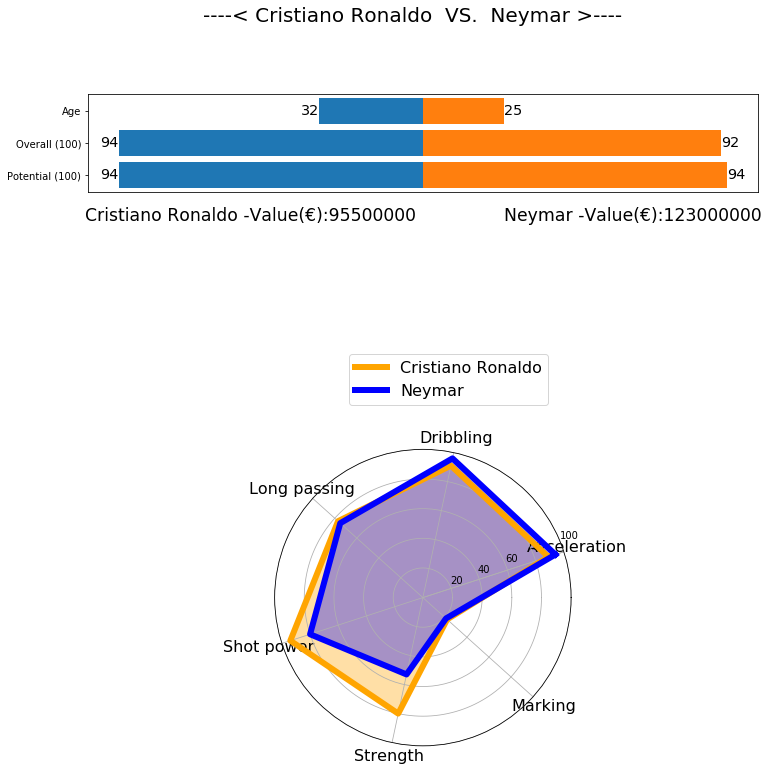

In [12]:
player_compare()
#for e.g. Cristiano Ronaldo,Neymar

### Part 2: Comparing two clubs' performance

<li>Write a function to find best squard in each formation for a club, which is used in comparison</li>
<li>Calculate players' average age, overall rate, potential rate, and value for each club</li>
<li>Use two-direction bar graph to visualize difference between two clubs</li>
<li>Calculate average of players'six skills which usually affect and reveal a club performance</li>
<li>Use radar graph to find each club's relative strengthes and weaknesses</li>
<li>Simply predict game results when two clubs use different formations and show results in a table</li>

In [13]:
# find best squard in each formation for a club
def club_formations(m):
    result = {}
    df_club = df[df['Club'] == m]
    for k in formation_choice.keys():
        club_formation_score = formation_matrix(df_club,formation_choice[k]) 
        result[k]=pd.DataFrame(club_formation_score,columns = ['Position','Name','Overall rate','Nationality','Club'])
    return result

# start to compare
def club_compare():  
    # to read the data
    df = pd.read_csv('CompleteDataset_modified.csv')
    
    # get the clubs'name that users want to compare
    names = input("Enter two clubs' names you want to compare(separated by ','): ")
    names = names.split(',')
    
    # to check if the club exists
    for i in names:
        if not i in df.Club.values:
            return "Sorry,the club %s doesn't exit."%i
    
    # deal with dataset and get variables from the input
    df[['Value']] = df[['Value']].astype(int)
    df = df.groupby('Club').mean()
    df.reset_index(level=0, inplace=True)
    name1 = names[0]
    name2 = names[1]
    
    # to visualize the comparing result
    fig = plt.figure(figsize=(10,12))
    fig.suptitle('----< %s  VS.  %s >----'%(name1,name2),fontsize = 20) 
    # to divid space for two graphs
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5]) 
    
    # 1.to draw bar graph to compare avg. age, avg overall rate, avg. potential
    df1 = df[(df['Club'] == name1)]
    value1 = df1['Value'].values[0]
    df1 = df1[['Potential','Overall','Age']]
    df1.columns = [['avg. Potential (100)','avg. Overall (100)','avg. Age']]
    df1 = df1.T
    df1.reset_index(level=0, inplace=True)
    df1.columns = ['property','data']
    x = df1['property']
    y1 = df1['data'].apply(lambda x : -x)
    
    df2 = df[(df['Club'] == name2)]
    value2 = df2['Value'].values[0]
    df2 = df2[['Potential','Overall','Age']]
    df2.columns = [['avg. Potential (100)','avg. Overall (100)','avg. Age']]
    df2 = df2.T
    df2.reset_index(level=0, inplace=True)
    df2.columns = ['property','data']
    y2 = df2['data']
    
    plt.subplot(gs[0])
    plt.barh(x, y1)
    plt.barh(x, y2)

    plt.xticks(())
    plt.xlabel('%s -Value(€):%d                %s -Value(€):%d'%(name1,value1,name2,value2),labelpad = 15, fontsize = 'xx-large')
    for x, y1, y2 in zip(x, y1, y2):
          #ha: horizontal alignmen
          #va: vertical alignment
        plt.text(y1, x, '%d' % -y1, ha='right', va = 'center', fontsize = 'x-large')  
        plt.text(y2, x, '%d' % y2 , ha='left',va = 'center', fontsize = 'x-large')
    
    # 2.to draw radar graph to compare avarage rates for six skills
    cols = ['Aggression','Ball control','Free kick accuracy','Heading accuracy','Finishing','Penalties']
        # to draw a circle divided into six part equally
    angles = np.linspace(0.1 * np.pi, 2.1 * np.pi, len(cols), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

        # initialize the graph
    plt.subplot(gs[1])
    plt.xticks(())
    plt.yticks(())
    plt.axis('off')
    ax = fig.add_subplot(212,polar=True)
    
        # draw two club's rates seperately
    df1 = df[(df['Club'] == name1)]
    stats = df1[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='orange', label='%s'%name1)
    ax.fill(angles, stats, c='orange', alpha=0.35)

    df2 = df[(df['Club'] == name2)]
    stats = df2[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='blue', label='%s'%name2)
    ax.fill(angles, stats, c='blue', alpha=0.35)

        # add legends
    ax.legend(loc=[0.25, 1.15], fontsize=16)
    ax.set_ylim(0,100)
    ax.set_thetagrids(angles * 180/np.pi, cols, fontsize=16)
    ax.grid(True)

    # 3.to show different game result when two club choose different team's formation--not done yet
    result1 = club_formations(name1)
    result2 = club_formations(name2)
    
        # get the result data
    game_data = list()
    formation_choice = ['433','424','442','343','451']
    for i in formation_choice:
        rate1 = result1[i].sum()['Overall rate']
        for j in formation_choice:
            rate2 = result1[j].sum()['Overall rate']
            #if club1's rate is more than club2's, predict club1 will win
            if rate1 > rate2:
                game = 'Win - Lose'
            #if club1's rate is less than club2's, predict club2 will win
            elif rate1 < rate2:
                game = 'Lose - Win'
            #otherwise, predict they tie in the game
            else:
                game = 'Tie'
            game_data.append([i,rate1,game,rate2,j])  
            
        # use prettytable to put the result in a table.
    table = PrettyTable(['Formation1','Overall rate1','Predicted result','Overall rate2','Formation2'])
    for i in game_data:
        table.add_row(i)
    print('------ NOTE:  1 represent %s,'%name1,'2 represent %s ------'%name2)
    print(table)

Enter two clubs' names you want to compare(separated by ','): Paris Saint-Germain,FC Barcelona
------ NOTE:  1 represent Paris Saint-Germain, 2 represent FC Barcelona ------
+------------+---------------+------------------+---------------+------------+
| Formation1 | Overall rate1 | Predicted result | Overall rate2 | Formation2 |
+------------+---------------+------------------+---------------+------------+
|    433     |      929      |       Tie        |      929      |    433     |
|    433     |      929      |    Win - Lose    |      927      |    424     |
|    433     |      929      |       Tie        |      929      |    442     |
|    433     |      929      |    Lose - Win    |      931      |    343     |
|    433     |      929      |    Win - Lose    |      925      |    451     |
|    424     |      927      |    Lose - Win    |      929      |    433     |
|    424     |      927      |       Tie        |      927      |    424     |
|    424     |      927      |    Lo

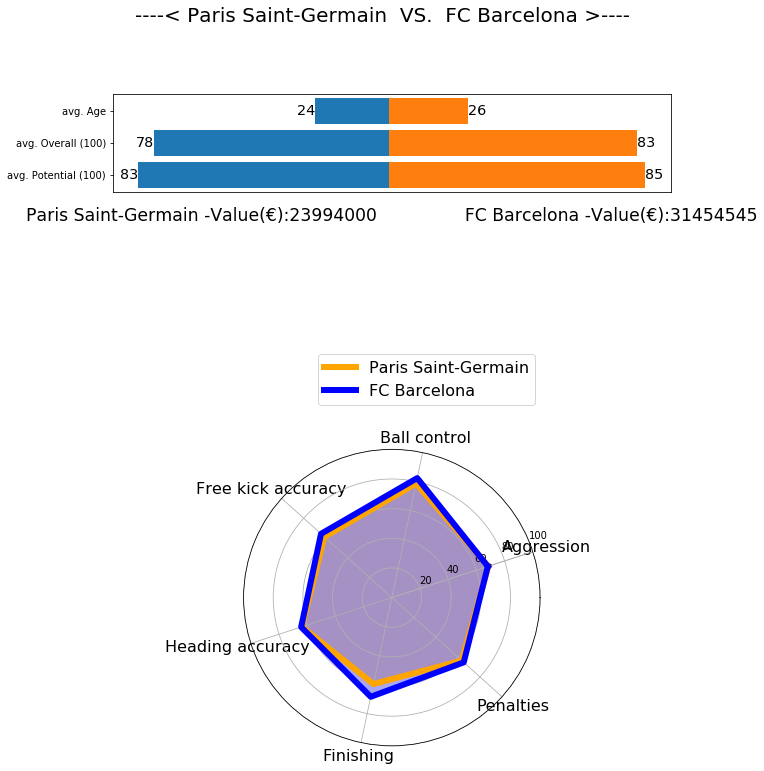

In [14]:
club_compare()
# for e.g. Paris Saint-Germain,FC Barcelona

### Part3: Comparing two countries' performance

<li>Write a function to find best squard in each formation for a country, which is used in comparison</li>
<li>Calculate players' average age, overall rate, potential rate, and value for each country</li>
<li>Use two-direction bar graph to visualize difference between two countries</li>
<li>Calculate average of players'six skills which usually affect and reveal a country performance</li>
<li>Use radar graph to find each country's relative strengthes and weaknesses</li>
<li>Simply predict game results when two countries use different formations and show results in a table</li>

In [15]:
def country_formations(x):
    result = {}
    df_country = df[df['Nationality'] == x]
    for i in formation_choice.keys():
        country_formation_score = formation_matrix(df_country,formation_choice[i]) 
        result[i]=pd.DataFrame(country_formation_score,columns = ['Position','Name','Overall rate','Nationality','Club'])
    return result
def Nationality_compare():  
    # to read the data
    df = pd.read_csv('CompleteDataset_modified.csv')
    
    # get the clubs'name that users want to compare
    names = input("Enter two Countries' names you want to compare(separated by ','): ")
    names = names.split(',')
    
    # to check if the club exists
    for i in names:
        if not i in df.Nationality.values:
            return "Sorry,the country %s doesn't exit."%i
    
    # deal with dataset and get variables from the input
    df[['Value']] = df[['Value']].astype(int)
    df = df.groupby('Nationality').mean()
    df.reset_index(level=0, inplace=True)
    name1 = names[0]
    name2 = names[1]
    
    # to visualize the comparing result
    fig = plt.figure(figsize=(10,12))
    fig.suptitle('----< %s  VS.  %s >----'%(name1,name2),fontsize = 20) 
    # to divid space for two graphs
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5]) 
    
    # 1.to draw bar graph to compare avg. age, avg overall rate, avg. potential
    df1 = df[(df['Nationality'] == name1)]
    value1 = df1['Value'].values[0]
    df1 = df1[['Potential','Overall','Age']]
    df1.columns = [['avg. Potential (100)','avg. Overall (100)','avg. Age']]
    df1 = df1.T
    df1.reset_index(level=0, inplace=True)
    df1.columns = ['property','data']
    x = df1['property']
    y1 = df1['data'].apply(lambda x : -x)
    
    df2 = df[(df['Nationality'] == name2)]
    value2 = df2['Value'].values[0]
    df2 = df2[['Potential','Overall','Age']]
    df2.columns = [['avg. Potential (100)','avg. Overall (100)','avg. Age']]
    df2 = df2.T
    df2.reset_index(level=0, inplace=True)
    df2.columns = ['property','data']
    y2 = df2['data']
    
    plt.subplot(gs[0])
    plt.barh(x, y1)
    plt.barh(x, y2)

    plt.xticks(())
    plt.xlabel('%s -Value(€):%d                %s -Value(€):%d'%(name1,value1,name2,value2),labelpad = 15, fontsize = 'xx-large')
    for x, y1, y2 in zip(x, y1, y2):
          #ha: horizontal alignmen
          #va: vertical alignment
        plt.text(y1, x, '%d' % -y1, ha='right', va = 'center', fontsize = 'x-large')  
        plt.text(y2, x, '%d' % y2 , ha='left',va = 'center', fontsize = 'x-large')
    
    # 2.to draw radar graph to compare avarage rates for six skills
    cols = ['Aggression','Ball control','Free kick accuracy','Heading accuracy','Finishing','Penalties']
        # to draw a circle divided into six part equally
    angles = np.linspace(0.1 * np.pi, 2.1 * np.pi, len(cols), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

        # initialize the graph
    plt.subplot(gs[1])
    plt.xticks(())
    plt.yticks(())
    plt.axis('off')
    ax = fig.add_subplot(212,polar=True)
    
        # draw two club's rates seperately
    df1 = df[(df['Nationality'] == name1)]
    stats = df1[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='orange', label='%s'%name1)
    ax.fill(angles, stats, c='orange', alpha=0.35)

    df2 = df[(df['Nationality'] == name2)]
    stats = df2[cols].values[0].tolist()
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='blue', label='%s'%name2)
    ax.fill(angles, stats, c='blue', alpha=0.35)

        # add lables
    ax.legend(loc=[0.25, 1.15], fontsize=16)
    ax.set_ylim(0,100)
    ax.set_thetagrids(angles * 180/np.pi, cols, fontsize=16)
    ax.grid(True)

    # 3.to show different game result when two club choose different team's formation--not done yet
    result1 = country_formations(name1)
    result2 = country_formations(name2)
    
        # get the result data
    game_data = list()
    formation_choice = ['433','424','442','343','451']
    for i in formation_choice:
        rate1 = result1[i].sum()['Overall rate']
        for j in formation_choice:
            rate2 = result1[j].sum()['Overall rate']
            if rate1 > rate2:
                game = 'Win - Lose'
            elif rate1 < rate2:
                game = 'Lose - Win'
            else:
                game = 'Tie'
            game_data.append([i,rate1,game,rate2,j])  
            
        # use prettytable to put the result in a table.
    table = PrettyTable(['Formation1','Overall rate1','Predicted result','Overall rate2','Formation2'])
    for i in game_data:
        table.add_row(i)
    print('------ NOTE:  1 represent %s,'%name1,'2 represent %s ------'%name2)
    print(table)

Enter two Countries' names you want to compare(separated by ','): Germany,France
------ NOTE:  1 represent Germany, 2 represent France ------
+------------+---------------+------------------+---------------+------------+
| Formation1 | Overall rate1 | Predicted result | Overall rate2 | Formation2 |
+------------+---------------+------------------+---------------+------------+
|    433     |      946      |       Tie        |      946      |    433     |
|    433     |      946      |    Win - Lose    |      938      |    424     |
|    433     |      946      |    Win - Lose    |      941      |    442     |
|    433     |      946      |    Lose - Win    |      957      |    343     |
|    433     |      946      |    Win - Lose    |      944      |    451     |
|    424     |      938      |    Lose - Win    |      946      |    433     |
|    424     |      938      |       Tie        |      938      |    424     |
|    424     |      938      |    Lose - Win    |      941      |   

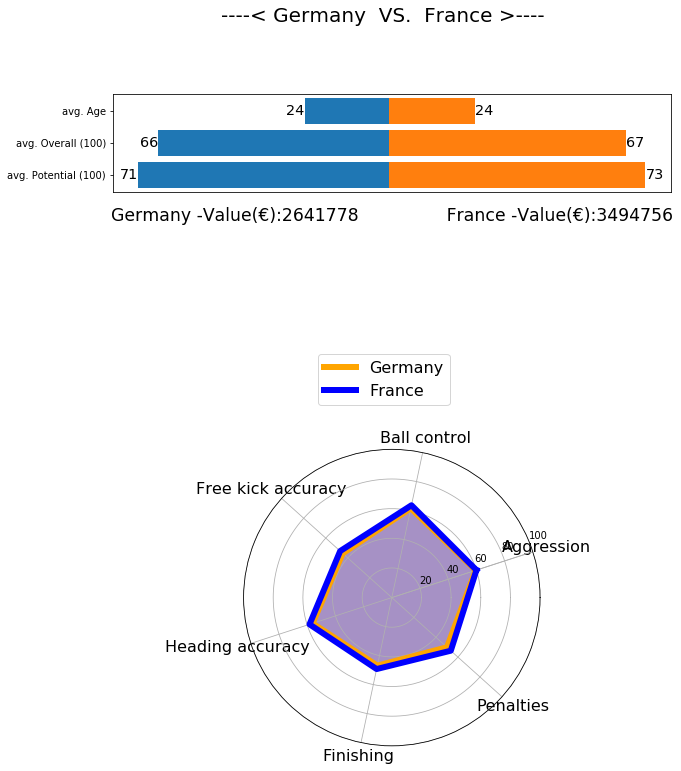

In [16]:
Nationality_compare()
#for e.g. Germany,France

## < Topic 3 > Is it worthwile to buy a player?

### Part1: Analyze the relationship between age and socre (overall and potential)

Calculate mean of overall and potential socres by age group   
Plot the trend between two factors: age and score (overall and potential)   
Mark out the point of the player user want to know, x_axis = age, y_axis = overall/potential

In [17]:
def Age_Score():
    df = pd.read_csv('CompleteDataset_modified.csv')
    n = input("Enter the player's name you want to know: ")
    if n in df.Name.values:
        index = list(df['Name']).index(n)
    else:
        return f"Sorry,the player {n} doesn't exit."

    # Save all non-repeating ages in the database as a list
    Age = list(set(df['Age']))

    # Calculate the mean of overall scores of players at each age
    gr_Overall = df['Overall'].groupby(df['Age'])
    Overall_mean = gr_Overall.mean()
    gr_Potential = df['Potential'].groupby(df['Age'])
    Potential_mean = gr_Potential.mean()

    x = df.loc[index,'Age']
    y_o = df.loc[index,'Overall']
    y_p = df.loc[index,'Potential']

    # Plot the relationship of age and scores
    plt.figure(figsize=(10,6))
    plt.plot(x,y_o,'b*',label='Player Overall')
    plt.plot(x,y_p,'r*',label='Player Potential')
    plt.plot(Age,Overall_mean,label='Total Overall')
    plt.plot(Age,Potential_mean,label='Total Potential')
    plt.xlabel('Age')
    plt.ylabel('Score')
    plt.legend(loc='upper right')
    plt.title('Relationship between Age and Score')
    
    Table0 = PrettyTable(["Player Name", "Age", "Overall Score", "Potential Score"])
    Table0.padding_width = 1 # One space between column edges and contents (default)
    Table0.add_row([n,x,y_o,y_p])
    print(Table0)

Enter the player's name you want to know: Danilo Pereira
+----------------+-----+---------------+-----------------+
|  Player Name   | Age | Overall Score | Potential Score |
+----------------+-----+---------------+-----------------+
| Danilo Pereira |  25 |       83      |        86       |
+----------------+-----+---------------+-----------------+


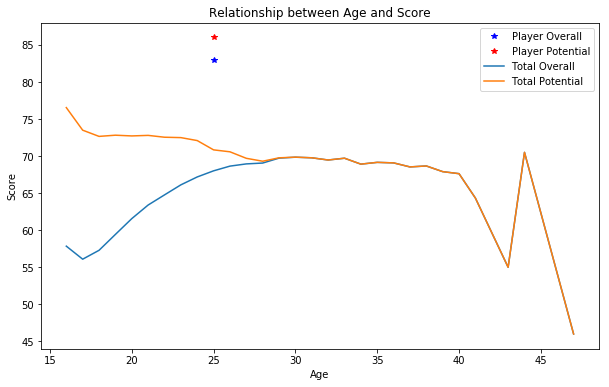

In [18]:
Age_Score()
##for e.g. Danilo Pereira

### Part2: Use multiple linear regression to find the relationship between age, potential and value

Normallize dataset, split training set and testing set  
Do multiple linear regression, response variable: value, explanatory variables: age and potential score  
Calculate Minimum Mean Square Error to test accuracy   
The aim of regression is to determine the weight of age and potential score, coefficiens will be used in next part

In [21]:
def regression():
    df = pd.read_csv('CompleteDataset_modified.csv')
    X1 = df.Overall
    X2 = df.Potential
    X3 = df.Age
    X = pd.concat([X1,X2,X3],axis=1)
    y = df.Value
    Z = pd.concat([X,y],axis=1)

    # data scaling
    Z_scaled = preprocessing.scale(Z)
    Z_scaled
    O = Z_scaled[:,0]
    P = Z_scaled[:,1]
    A = Z_scaled[:,2]
    V = Z_scaled[:,3]
    PA = np.c_[P,A]

    # determine training set and testing set
    P_train,P_test, V_train, V_test = train_test_split(P, V, random_state=1)
    A_train,A_test, V_train, V_test = train_test_split(P, V, random_state=1)
    PA_train,PA_test, V_train, V_test = train_test_split(PA, V, random_state=1)

    # regression
    rg = LinearRegression()
    model = rg.fit(PA_train,V_train)
    b = round(rg.intercept_,4) # intercept of regression equation
    k1 = round(rg.coef_[0],4)
    k2 = round(rg.coef_[1],4)

    # use testing set to predict
    V_pred = rg.predict(PA_test)

    # 3-dimensional scatter plot
    fig1=plt.figure(figsize=(12,6))
    ax=fig1.gca(projection='3d') 
    ax.scatter(P_test,A_test,V_test,c='b',label='Real Scatter')
    x = np.linspace(-4,3)
    y = np.linspace(-4,3)
    def f(x,y): # Define the function for finding the z coordinate, i.e. calculate the value of the z coordinate using the regression equation
        return rg.coef_[0] * x + rg.coef_[1] * y + rg.intercept_ 
    x,y= np.meshgrid(x,y)
    zs = np.array([f(x,y) for x,y in zip(np.ravel(x), np.ravel(y))]) # Use list comprehension to determine the list of z
    z=zs.reshape(x.shape) # Reshape z to fit the shape of x, just for plot
    
    # plot the curve surface
    ax1=ax.plot_surface(x,y,z,alpha=0.3) 
    ax.set_xlabel('Potential')
    ax.set_ylabel('Age')
    ax.set_zlabel('Value')
    ax.set_title('Regression Result')
    plt.show()
    
    # calculate the Minimum Mean Square Error
    sum_mean=0
    for i in range(len(V_pred)):
        sum_mean += (V_pred[i] - V_test[i]) ** 2
    sum_error = round(np.sqrt(sum_mean / len(V_test)),4) # MSE is mean of square errors(error = predicted V - test V)

    from prettytable import PrettyTable
    Table = PrettyTable(["Coefficient of x_potential", "Coefficient of x_age", "Intercept", "Minimum Mean Square Error"])
    Table.padding_width = 1
    Table.add_row([k1,k2,b,sum_error])
    print(Table)

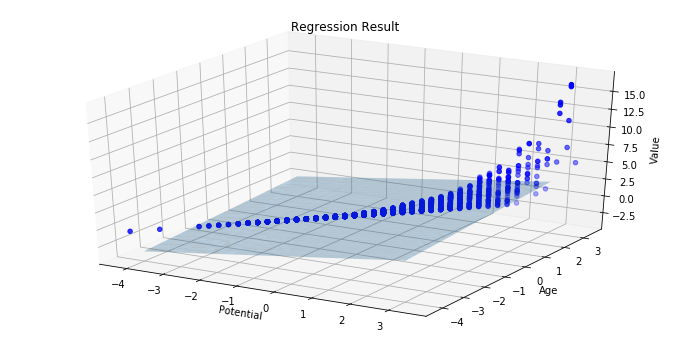

+----------------------------+----------------------+-----------+---------------------------+
| Coefficient of x_potential | Coefficient of x_age | Intercept | Minimum Mean Square Error |
+----------------------------+----------------------+-----------+---------------------------+
|           0.6463           |        0.2336        |  -0.0015  |           0.7828          |
+----------------------------+----------------------+-----------+---------------------------+


In [22]:
regression()

### Part3: Polyfit curve of age-value, potential-value, and overall-value, help decide whether to buy a certain player

Calculate the median value of each age group, overall score group and potential score group    
Separately polyfit the relationship of value and three factors: age, overall score, and potential score     
Combine the regression result and polyfitting result to make decision    
Decision criterion:    
- real value = value of the player user want to know    
- val_age = polyfitted value at the same age     
- val_potential = polyfitted value at the same potential score      
       
-- if real value is higher than both val_age and val_potential, not worth buying    
-- if real value is lower than both val_age and val_potential, worth buying    
-- if real value is between val_age and val_potential, we give the difference of real value and polyfitted value a weight     
--    (weight equals to the regression coefficient)      
--    if the sum of weighted differences is positive, worth buying     
--    if the sum of weighted differences is negative, not worth buying

In [23]:
def Value():
    df = pd.read_csv('CompleteDataset_modified.csv')
    n = input("Enter the player's name you want to know: ")
    if n in df.Name.values:
        index = list(df['Name']).index(n)
    else:
        return f"Sorry,the player {n} doesn't exit." 

    # Find out median values by different groups
    gr_Age = df['Age'].groupby(df['Age'])
    Age_median = gr_Age.median()
    gr_Value1 = df['Value'].groupby(df['Age'])
    Value1_median = gr_Value1.median() # find meadian value of each age section
    gr_Overall = df['Overall'].groupby(df['Overall'])
    Overall_median = gr_Overall.median()
    gr_Value2 = df['Value'].groupby(df['Overall'])
    Value2_median = gr_Value2.median()# find meadian value of each overall score section
    gr_Potential = df['Potential'].groupby(df['Potential'])
    Potential_median = gr_Potential.median()
    gr_Value3 = df['Value'].groupby(df['Potential'])
    Value3_median = gr_Value3.median()# find meadian value of each potential score section


    # Polyfitting
    lst_age = list(Age_median) # change the type of age from array to list
    lst_overall = list(Overall_median)
    lst_potential = list(Potential_median)
    lst_value1 = list(Value1_median)
    lst_value2 = list(Value2_median)
    lst_value3 = list(Value3_median)
    fa = np.polyfit(lst_age, lst_value1, 4) # fit a polynomial of degree 4
    plya = np.poly1d(fa) # construct the polynomial
    fo = np.polyfit(lst_overall, lst_value2, 4)
    plyo = np.poly1d(fo)
    fp = np.polyfit(lst_potential, lst_value3, 5)
    plyp = np.poly1d(fp)

    # store polyfitting value
    vala = plya(lst_age)
    valo = plyo(lst_overall)
    valp = plyp(lst_potential) 

    # define the axis of x and y
    x_a = df.loc[index,'Age']
    x_o = df.loc[index,'Overall']
    x_p = df.loc[index,'Potential']
    y_v = int(df.loc[index,'Value'])

    # Plot the polyfitting curve
    fig = plt.figure(figsize=(8,5))
    plt.scatter(Age_median, Value1_median, label='Real Value')
    plot1 = plt.plot(Age_median, vala, 'r',label='Polyfit Curve')
    t = x_a
    ind = lst_age.index(t) # find the index of t in the list: lst_age
    y_a = float(list(vala)[ind]) # determine the polyfitted value of t and make it a float number
    plt.vlines(t,-1e05,y_a, color ='#FFA500', linewidth=2, linestyle="--") # draw a vertical line: x = t, y from -1e05 to y_a
    plt.hlines(y_a,14,t, color ='#FFA500', linewidth=2, linestyle="--") # draw a horizontal line: y = y_a, x from 14 to t
    plt.xlabel('Age')
    plt.ylabel('Value')
    plt.xlim(14, 42)
    plt.ylim(-1e05, 1.25e06)
    plt.legend(loc='best')
    plt.title('Age-Value Polyfitting')

    fig_ply = plt.figure(figsize=(12,8))
    p2 = fig_ply.add_subplot(121)
    plt.scatter(Overall_median, Value2_median, label='Real Value')
    plot2 = plt.plot(Overall_median, valo, 'r',label='polyfit curve')
    t = x_o
    ind = lst_overall.index(t)
    y_o = float(list(valo)[ind])
    plt.vlines(t,-2e06,y_o, color ='#FFA500', linewidth=2, linestyle="--")
    plt.hlines(y_o,40,t, color ='#FFA500', linewidth=2, linestyle="--")
    plt.xlabel('Overall')
    plt.ylabel('Value')
    plt.xlim(40, 100)
    plt.ylim(-2e06, 1.2e08)
    plt.legend(loc='best')
    plt.title('Overall-Value polyfitting')

    p3 = fig_ply.add_subplot(122)
    plt.scatter(Potential_median, Value3_median, label='Real Value')
    plot2 = plt.plot(Potential_median, valp, 'r',label='polyfit curve')
    t = x_p
    ind = lst_potential.index(t)
    y_p = float(list(valp)[ind])
    plt.vlines(t,-2e06,y_p, color ='#FFA500', linewidth=2, linestyle="--")
    plt.hlines(y_p,40,t, color ='#FFA500', linewidth=2, linestyle="--")
    plt.xlabel('Potential')
    plt.ylabel('Value')
    plt.xlim(40, 100)
    plt.ylim(-2e06, 1.2e08)
    plt.legend(loc='best')
    plt.title('Potential-Value polyfitting')
    plt.show()
    
    # decide whether it is worthwile to buy the certain player or not
    k1 = 0.6463
    k2 = 0.2336
    diffp = y_p - y_v
    diffa = y_a - y_v
    cpare = k1 * diffp + k2 * diffa # use the coefficient of regression to compare
    if y_v < y_a and y_v < y_p:
        dec = (f'The player {n} has high performance-value ratio, worth buying')
    elif y_v > y_a and y_v > y_p:
        dec = (f"The player {n} doesn't have high performance-value ratio, please think carefully before buying")
    elif y_v < y_a and y_v > y_p:
        if cpare > 0:
            dec = (f'The player {n} has high performance-value ratio, worth buying')
        else:
            dec = (f"The player {n} doesn't have high performance-value ratio, please think carefully before buying")
    elif y_v > y_a and y_v < y_p:
        if cpare > 0:
            dec = (f'The player {n} has high performance-value ratio, worth buying')
        else:
            dec = (f"The player {n} doesn't have high performance-value ratio, please think carefully before buying")
    else:
        dec = (f'The player {n} has high performance-value ratio, worth buying')
        
    diffp = round(y_v - y_p, 2)
    diffa = round(y_v - y_a, 2)
    
    # Draw the table of player's information
    print()
    print('\033[1;34m --------- Notice: positive number means higher then median value, negative number means lower than median value ---------\033[0m')
    Table1 = PrettyTable(["Name", "Age", "Potential", "Value","Differnce with median value of same age","Differnce with median value of same potential"])
    Table1.padding_width = 1
    Table1.add_row([n,x_a,x_p,y_v,diffa,diffp])
    print(Table1)
    print()
    print()
    Table2 = PrettyTable(["Plaer Name", "Decision"])
    Table2.padding_width = 1
    Table2.add_row([n, dec])
    print(Table2)

Enter the player's name you want to know: Pepe


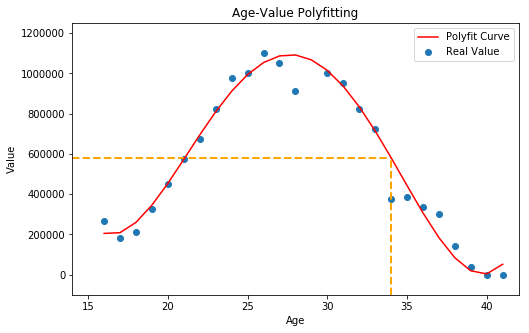

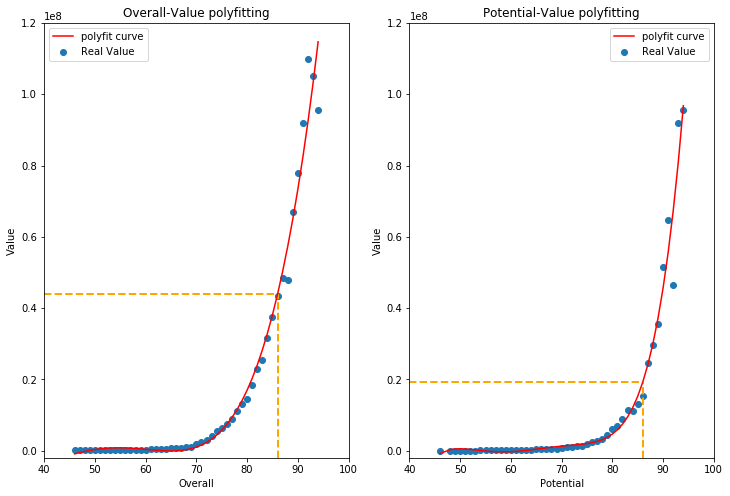


 --------- Notice: positive number means higher then median value, negative number means lower than median value ---------
+------+-----+-----------+----------+-----------------------------------------+-----------------------------------------------+
| Name | Age | Potential |  Value   | Differnce with median value of same age | Differnce with median value of same potential |
+------+-----+-----------+----------+-----------------------------------------+-----------------------------------------------+
| Pepe |  34 |     86    | 13500000 |               12918571.79               |                  -5746257.37                  |
+------+-----+-----------+----------+-----------------------------------------+-----------------------------------------------+


+------------+----------------------------------------------------------------+
| Plaer Name |                            Decision                            |
+------------+------------------------------------------------------------

In [24]:
Value()
## for e.g. Pepe

### Part4: Ten cost-effective players with highet overall socre

From the whole dataset, use the same determine standard to find out all players who are worth buying   
Since the dataset is ordered by 'Overall', select the first ten players' information, store as array    
Sort 10 players' data in descending order of colomn 'potential'

In [25]:
def worthbuy(): 
    df = pd.read_csv('CompleteDataset_modified.csv')
    idx = []
    gr_Age = df['Age'].groupby(df['Age'])
    Age_median = gr_Age.median()
    gr_Value1 = df['Value'].groupby(df['Age'])
    Value1_median = gr_Value1.median() # find meadian value of each age section
    gr_Potential = df['Potential'].groupby(df['Potential'])
    Potential_median = gr_Potential.median()
    gr_Value3 = df['Value'].groupby(df['Potential'])
    Value3_median = gr_Value3.median()
    lst_age = list(Age_median) # change the type of age from array to list
    lst_potential = list(Potential_median)
    lst_value1 = list(Value1_median)
    lst_value3 = list(Value3_median)
    fa = np.polyfit(lst_age, lst_value1, 4) # fit a polynomial of degree 4
    plya = np.poly1d(fa) # construct the polynomial
    fp = np.polyfit(lst_potential, lst_value3, 5)
    plyp = np.poly1d(fp)

    # store polyfitting value
    vala = plya(lst_age)
    valp = plyp(lst_potential) 
    
    # use our regression result
    k1 = 0.6463
    k2 = 0.2336
    
    for i in df.ix[:,0]: # determine index
        v_i = df.loc[i,'Value'] # find value for index i
        j = df.loc[i,'Potential'] # find potential for index i
        h = df.loc[i,'Age'] # find age for index i
        inx1 = lst_potential.index(j) # determine index in potential list, in order to find polyfitting value
        vpred_ip = float(list(valp)[inx1]) # find polyfitting value of certian potential
        inx2 = lst_age.index(h)
        vpred_ia = float(list(valp)[inx2])
        diffp = vpred_ip - v_i
        diffa = vpred_ia - v_i
        cpare = k1 * diffp + k2 * diffa
        if v_i < vpred_ip and v_i < vpred_ia:
            idx.append(i)
        elif v_i < vpred_ip and v_i > vpred_ia:
                if cpare > 0:
                    idx.append(i)
                else:
                    continue
        elif v_i > vpred_ip and v_i < vpred_ia:
                if cpare > 0:
                    idx.append(i)
                else:
                    continue
    
    name = []
    nationality = []
    club = []
    potential = []
    overall = []
    age = []
    value = []
    for m in range(10):
        name.append(df.loc[idx[m],'Name']) # create a list to store first 10 players' name
        nationality.append(df.loc[idx[m],'Nationality'])
        club.append(df.loc[idx[m],'Club'])
        potential.append(df.loc[idx[m],'Potential'])
        overall.append(df.loc[idx[m],'Overall'])
        age.append(df.loc[idx[m],'Age'])
        value.append(df.loc[idx[m],'Value'])
    
    # turn the 4 lists into one array, shape is 4*10
    data_rows = np.array([name,nationality,club,age,overall,potential,value])
    # transpose data_rows into an array with shape 10*4
    data = data_rows.T
    data = data[data[:,5].argsort()[::-1]] #sort the data in descending order of column 'potential' 
    
    # draw a table of first 10 players
    Table3 = PrettyTable(["Name", "Nationality", "Club", "Age", "Overall", "Potential", "Value(€)"])
    Table3.padding_width = 3
    for i in data:
        Table3.add_row(i)
    print(Table3)

In [26]:
worthbuy()

/Users/yahanhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


+-------------------+-----------------+-------------------------+---------+-------------+---------------+----------------+
|        Name       |   Nationality   |           Club          |   Age   |   Overall   |   Potential   |    Value(€)    |
+-------------------+-----------------+-------------------------+---------+-------------+---------------+----------------+
|     K. Mbappé     |      France     |   Paris Saint-Germain   |    18   |      83     |       94      |   41500000.0   |
|     O. Dembélé    |      France     |       FC Barcelona      |    20   |      83     |       92      |   40000000.0   |
|   Marco Asensio   |      Spain      |      Real Madrid CF     |    21   |      84     |       92      |   46000000.0   |
|     R. Varane     |      France     |      Real Madrid CF     |    24   |      85     |       92      |   46500000.0   |
|      L. Sané      |     Germany     |     Manchester City     |    21   |      82     |       91      |   34500000.0   |
|      T. Lemar 

## < Topic 4 > What's the required ability for every position?

### Step 1: Calculate the Mean for every position
$ $
<li>The variables use is in the list variables.
<li>Write the Group Func to group by the position for df.</li>
<li>groupby_position return the data of the mean of every variable group by positions.
</li>


In [27]:
import pandas as pd
import numpy as np
d = pd.read_csv('CompleteDataset_modified.csv')
def GropFunc(ind,col,data,position):
    if position in data.loc[ind,col]:
        return position
    else:
        return False
def groupby_position(data,positions,variables):
    data_ = pd.DataFrame(np.zeros(len(variables)))
    result = data_.transpose()
    result.columns = variables
    for i in positions:
        grouped = d.groupby(lambda x:GropFunc(x,'Preferred Positions',data,i))
        result.loc[i]=grouped.mean()[variables].loc[i]
    return result
data = groupby_position(d,l,variables)

### Step 2: Choose the K for PCA
$ $
<li>
    Use the PCA library to compute the Cumulative Variance </li>
<li>Draw it by matplot</li>
<li>From the picture we know that when k=3, the value almost reach 100, after 3, the change is small so we choose k=3

[ 85.    97.66  98.98  99.85  99.92  99.96  99.98  99.99 100.   100.
 100.   100.   100.   100.   100.  ]


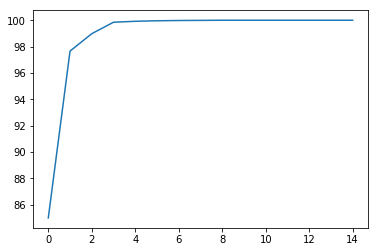

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline
#Change the dataframe to matrix
X=data.values
#Scaling the values
X = scale(X)
pca = PCA(n_components=31)
pca.fit(X)
var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(var1)
plt.plot(var1)

### Step 3: Write the pca function to analysis, k = 3
$ $
<li>
    Calculate the mean for the data by colunms and normalize the data </li>
<li>Calculate the Convariance Matrix</li>
<li>Calculate the eigenvector and eigvalues 
<li>Find the eigenvector with top three biggest eigvalues
<li>Reduce the demesion of the original data
<li>Change the result to DataFrame

In [29]:
def pca(data_pca,n):
    meanVal=np.mean(data_pca,axis=0)
    newData=data_pca-meanVal
    covMat=np.cov(newData,rowvar=0)
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))
    eigValIndice=np.argsort(eigVals) 
    n_eigValIndice=eigValIndice[-1:-(n+1):-1] 
    n_eigVect=eigVects[:,n_eigValIndice]
    lowDDataMat=newData.values*n_eigVect
    return n_eigVect,lowDDataMat
name = ['Special','Attack-Defence','Dribble-Accuracy']
result,result_position = pca(data.iloc[1:],3)
result_position = pd.DataFrame(result_position,columns = name)
result_position.index = l
result_position

,Special,Attack-Defence,Dribble-Accuracy
RB,(-22.436901065674896+0j),(-36.53672539181189+0j),(8.155966216040616+0j)
LM,(22.674998982524333+0j),(23.278379155761183+0j),(3.9299335330978495+0j)
RM,(14.687675392780152+0j),(23.353532672164032+0j),(4.8932132593778075+0j)
CF,(15.591002993292404+0j),(45.22058190591776+0j),(-5.056263422557977+0j)
CDM,(55.493203067126146+0j),(-37.39476144893547+0j),(-19.27432920082793+0j)
ST,(-70.51634316529731+0j),(57.7607337553495+0j),(-5.6410394487532844+0j)
LW,(5.421884798432128+0j),(28.810524483432694+0j),(6.911891647859346+0j)
CM,(57.303417363997134+0j),(-18.49405387570955+0j),(-14.711215958409024+0j)
RWB,(25.283738392545963+0j),(-30.112384633613928+0j),(10.343606235145517+0j)
CB,(-166.27941607523664+0j),(-36.844884414172526+0j),(-7.584573496657638+0j)


In [30]:
result = pd.DataFrame(result,columns = name)
result.index = variables
result

,Special,Attack-Defence,Dribble-Accuracy
Age,(-0.0006416700561159813+0j),(-0.007797445156171187+0j),(-0.020719951638890538+0j)
Special,(0.9602758975660172+0j),(-0.1396523361374238+0j),(-0.03571784027569817+0j)
Acceleration,(0.042544648160109805+0j),(0.07657861456167238+0j),(0.423950625861797+0j)
Aggression,(-0.012048488654903286+0j),(-0.17746716030267215+0j),(-0.13520405019563464+0j)
Agility,(0.06454888345559437+0j),(0.09107320741058411+0j),(0.24751857815210046+0j)
Balance,(0.06333511383087384+0j),(0.05961134762968646+0j),(0.1836867484972941+0j)
Ball control,(0.05193185972811465+0j),(0.06907089210329609+0j),(-0.02254360058425536+0j)
Composure,(0.01789540967453497+0j),(0.023231951840845325+0j),(-0.10968177546281498+0j)
Crossing,(0.07959667374844868+0j),(0.004297840499569583+0j),(0.37470966563368585+0j)
Curve,(0.08067944314858205+0j),(0.10520833925877192+0j),(0.05988391140986311+0j)


### Step 4: Visualize the result
$ $
<li>Change the result DataFrame to dict, for every new variable, the original variables has been divided into two part, one is positive another is negative. And only when the coefficient of the origin variable is bigger than 0.1, will it show in the picture.</li>
<li>Plot it by WordCloud, the weight is the coeffienct. On the left are the positive variables, on the right are the negative variables</li>
<li>Find the relationship between new four variables and the original variables. And summarize what is the ability that the new variables represent.

In [31]:
data_visulization = result.astype(float)
def Change_dataframe_to_cloud_data(data):
    dics = []
    for i in data.columns:
        dic_plus = dict()
        dic_minus = dict()
        for j in data.index:
            if abs(data.loc[j,i])>0.1:
                if data.loc[j,i]>0:
                    dic_plus[j] = data.loc[j,i]
                else:
                    dic_minus[j] = abs(data.loc[j,i])
        dics.append(dic_plus)
        dics.append(dic_minus) 
    return dics
dics = Change_dataframe_to_cloud_data(data_visulization)

/Users/yahanhu/anaconda3/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:730: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


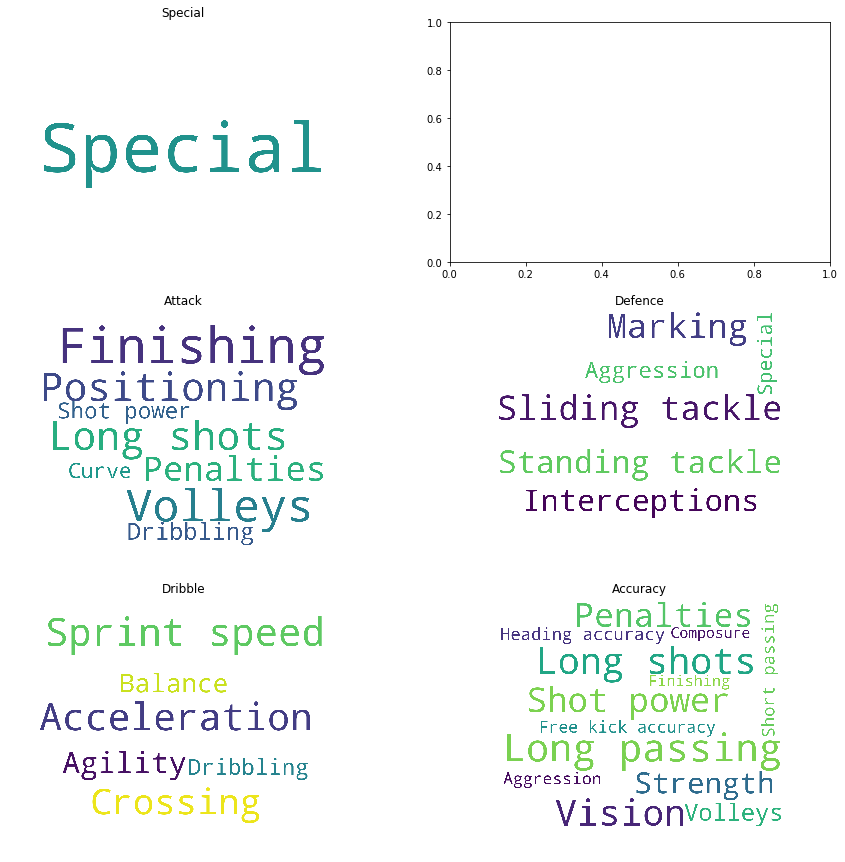

In [32]:
name_graph = ['Special','','Attack','Defence','Dribble','Accuracy']
import wordcloud
def plot():
    COL_NUM = 2
    ROW_NUM = 3
    fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,15))
    for i in range(6):
        if i ==1:
            continue
        cloud = wordcloud.WordCloud(background_color='white',width=1200,height=1000,max_words=20)
        frequencies = dics[i]
        cloud.fit_words(frequencies)
    #     plt.figure(figsize=(15,15))
        ax = axes[i//2, i%2] 
        ax.set_title(name_graph[i])
        ax.imshow(cloud)
        ax.axis('off')
#     plt.imshow(cloud) # 在坐标轴上显示图像
#     plt.axis("off") # 去除图像坐标轴
    plt.show()
plot()

### Step 5: Find the important Abilities for positions
For every value, if it is negative, it means that the ability of the left side is important. For example, if Dribble_Accuracy is -20, it means that Accuracy is important. And the bigger the number is, the more important the ability is.

Choose a country you are interested in
CF


/Users/yahanhu/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


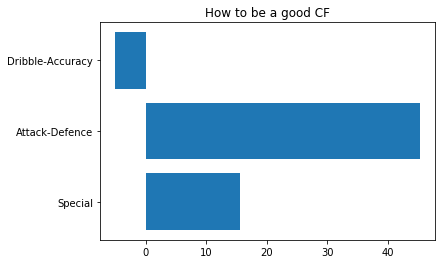

In [33]:
def show_ability_position():
    position = input("Choose a country you are interested in\n")
    plt.barh( name,result_position.loc[position])
    plt.title('How to be a good '+position)
show_ability_position()
###The input could be 'RB','LM','RM','CF','CDM','ST','LW','CM','RWB','CB','LWB','RW','CAM','LB'